In [9]:
import os
import numpy as np
import anndata
import re
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv
import scanpy as sc
import json
import scvi
import glob
import seaborn as sns
import copy
import random
import scipy.sparse as sp_sparse
import scipy.stats as sp_stats
from datetime import datetime
from joblib import parallel_backend
from joblib import Parallel, delayed
from igraph import *
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as scores
import pickle as pkl

import yaml
current_script_dir = os.getcwd()
config_file_path = os.path.abspath(os.path.join(current_script_dir, 'SEA-AD_utils/config/params.yaml'))
with open(config_file_path, 'r') as file:
    params = yaml.safe_load(file)

import sys
sys.path.insert(0, params['model']['model_path']) # Path to cell-tools

import cell_tools.model as cellmodel # import scvi_self.model as scvimodel
import cell_tools.run as cellrun # import scvi_self.run as scvirun
import cell_tools.tool as celltl # import scvi_self.tool as scvitl


%matplotlib inline

warnings.filterwarnings("ignore")

## Load data

In [10]:
adata = sc.read_h5ad(filename=params['data']['balanced_path'])

In [11]:
list(adata.obs.keys())

['sample_id',
 'Neurotypical reference',
 'Donor ID',
 'Organism',
 'Brain Region',
 'Sex',
 'Gender',
 'Age at Death',
 'Race (choice=White)',
 'Race (choice=Black/ African American)',
 'Race (choice=Asian)',
 'Race (choice=American Indian/ Alaska Native)',
 'Race (choice=Native Hawaiian or Pacific Islander)',
 'Race (choice=Unknown or unreported)',
 'Race (choice=Other)',
 'specify other race',
 'Hispanic/Latino',
 'Highest level of education',
 'Years of education',
 'PMI',
 'Fresh Brain Weight',
 'Brain pH',
 'Overall AD neuropathological Change',
 'Thal',
 'Braak',
 'CERAD score',
 'Overall CAA Score',
 'Highest Lewy Body Disease',
 'Total Microinfarcts (not observed grossly)',
 'Total microinfarcts in screening sections',
 'Atherosclerosis',
 'Arteriolosclerosis',
 'LATE',
 'Cognitive Status',
 'Last CASI Score',
 'Interval from last CASI in months',
 'Last MMSE Score',
 'Interval from last MMSE in months',
 'Last MOCA Score',
 'Interval from last MOCA in months',
 'APOE Genotype

In [19]:
donors = pd.DataFrame(adata.obs[["Overall AD neuropathological Change", "Donor ID"]]).drop_duplicates()

In [21]:
donors["Overall AD neuropathological Change"].value_counts()
# Revised:
#  - Split 80:20 within each celltype

Overall AD neuropathological Change
High            42
Intermediate    21
Low             12
Not AD           9
Reference        5
Name: count, dtype: int64

In [36]:
adata.obs["Donor ID"].value_counts()

Donor ID
H19.30.001    5221
H18.30.002    3248
H19.33.004    3204
H19.30.002    3157
H20.33.005    2661
              ... 
H21.33.046     592
H20.33.036     575
H21.33.034     441
H20.33.038     339
H21.33.020     193
Name: count, Length: 89, dtype: int64

In [10]:
adata.obs["Donor ID"]

exp_component_name
CATCAAGTCGGATACT-L8TX_210729_01_G12-1153814338                          H21.33.035
TGCTGAAAGCGATCGA-L8TX_210415_01_E11-1153814186                          H21.33.007
AAGCCATGTGATATAG-LKTX_191204_01_F01-1156636535                          H19.30.001
TCGATTTGTCGTGATT-L8TX_210715_01_D05-1153814295                          H20.33.032
CGCCAGATCAACCTTT-L8TX_210722_01_B07-1153814297                          H20.33.034
                                                                           ...    
TTCATGTTCAGTCACA-L8TX_210430_01_C04-1142430413_aug_2cells_comb_814-1    H20.33.001
ATCGCCTAGTCTGCAT-L8TX_210430_01_D05-1142430407_aug_2cells_comb_815-1    H20.33.025
CCGAACGAGAGTCTGG-L8TX_210430_01_C04-1142430413_aug_2cells_comb_816-1    H20.33.001
GTGAGGATCACTCCGT-L8TX_201030_01_B12-1142430231_aug_2cells_comb_817-1    H20.33.015
CGCCAGAAGGTACCTT-L8TX_210729_01_C12-1153814340_aug_2cells_comb_818-1    H21.33.034
Name: Donor ID, Length: 139000, dtype: category
Categories (89, obje

## Run CELL

In [5]:
model_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/XGKM/playground/Aditi/outputs"
cell_model_path = os.path.join(model_path, "cell_baseline")
batch_size = 128
max_epochs = 500
cell_model, cell_kwargs = cellrun.run_CELL(adata, 
                                           cell_model_path, 
                                           batch_key="method",
                                           categorical_covariate_keys=["library_prep"],
                                           batch_size=batch_size,
                                           max_epochs=max_epochs
                                          )

INFO     File                                                                                                      
         /allen/programs/celltypes/workgroups/rnaseqanalysis/XGKM/playground/Aditi/outputs/cell_baseline/model.pt  
         already downloaded                                                                                        


## Plot Latents

CELL model has been clustered before!


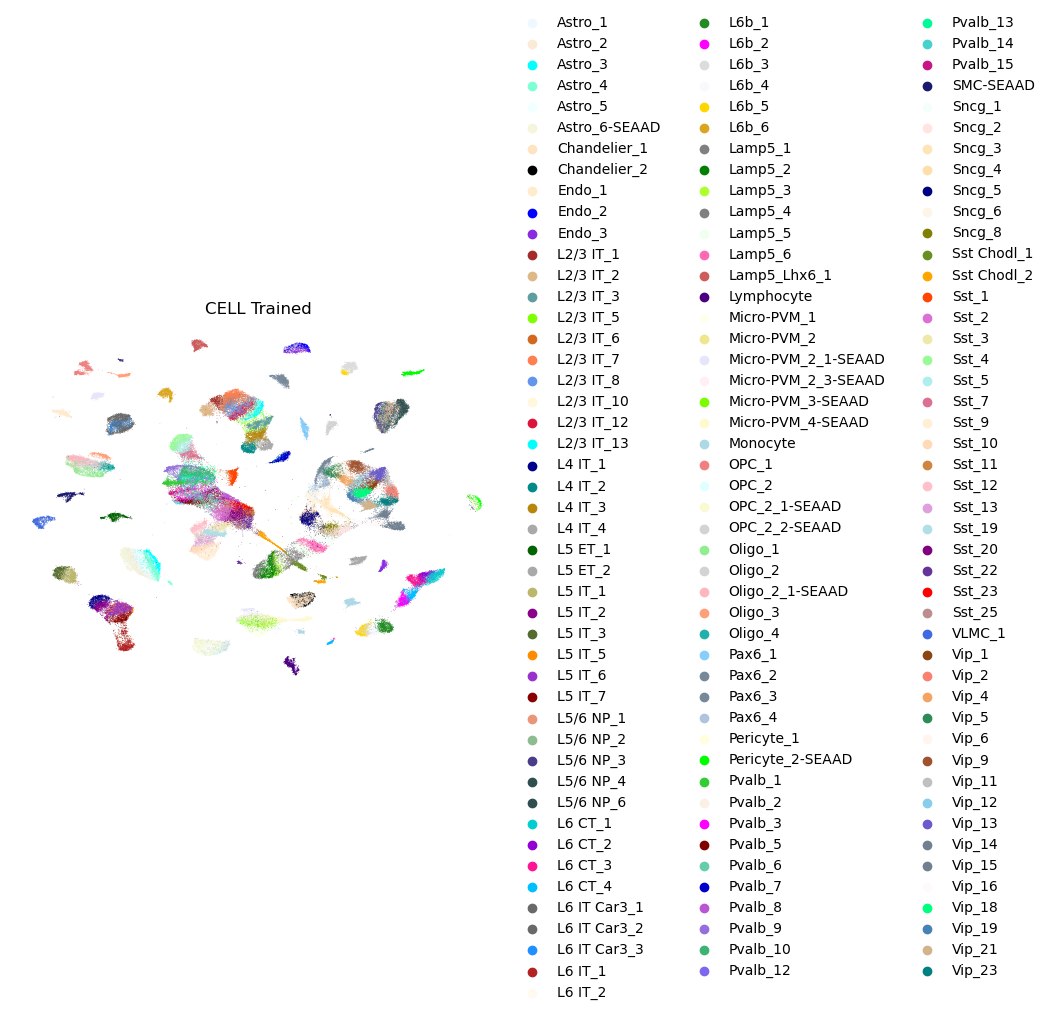

In [4]:
if os.path.exists(os.path.join(cell_model_path, "CELL.h5ad")) and os.path.exists(os.path.join(cell_model_path, 'CELL_umap.pkl')):
        print("CELL model has been clustered before!" )
        adata_CELL = sc.read_h5ad(filename=os.path.join(cell_model_path, "CELL.h5ad"))
        umap_model = pkl.load(open(os.path.join(cell_model_path, 'CELL_umap.pkl'),'rb'))
else:
        cell_model = cellmodel.CELL.load(cell_model_path, adata)
        adata_CELL = adata.copy()
        latent = cell_model.get_latent_representation(adata_CELL)
        adata_CELL.obsm["CELL"] = latent
        sc.pp.neighbors(adata_CELL, use_rep="CELL") # Using latent representation to form neighbors
        _, umap_model = celltl.umap(adata_CELL, min_dist=0.3, method='rapids')
        adata_CELL.write_h5ad(filename=os.path.join(cell_model_path, "CELL.h5ad"))
        pkl.dump(umap_model, open(os.path.join(cell_model_path, 'CELL_umap.pkl'), 'wb'))

sc.pl.umap(
        adata_CELL,
        color=["Supertype"], 
        palette = list(mpl.colors.CSS4_COLORS.values()), 
        frameon=False,
        title="CELL Trained"
        ) # show the cell before classification

## Run CELLBLAST Model

In [6]:
cellblast_max_epochs = 10
cellblast_batch_size = 128
label_model_path = os.path.join(model_path, "blast_baseline")
blast_kwargs = cellrun.run_CELLBLAST(
        adata=adata,
        model_dir = cell_model_path,
        label_model_dir = label_model_path,
        CELL_kwargs = cell_kwargs,
        batch_key="method",
        categorical_covariate_keys=["library_prep"],
        splitby="method",
        labels_key="Supertype",
        cellblast_max_epochs = 10,
        cellblast_batch_size = 128
    )

INFO     File                                                                                                      
         /allen/programs/celltypes/workgroups/rnaseqanalysis/XGKM/playground/Aditi/outputs/cell_baseline/model.pt  
         already downloaded                                                                                        


CELLBLAST model: /allen/programs/celltypes/workgroups/rnaseqanalysis/XGKM/playground/Aditi/outputs/blast_baseline_0 has been evaluated!
CELLBLAST model: /allen/programs/celltypes/workgroups/rnaseqanalysis/XGKM/playground/Aditi/outputs/blast_baseline_1 has been evaluated!
CELLBLAST model: /allen/programs/celltypes/workgroups/rnaseqanalysis/XGKM/playground/Aditi/outputs/blast_baseline_2 has been evaluated!


## Plot CELLBLAST Latents

BLAST model has been clustered before!


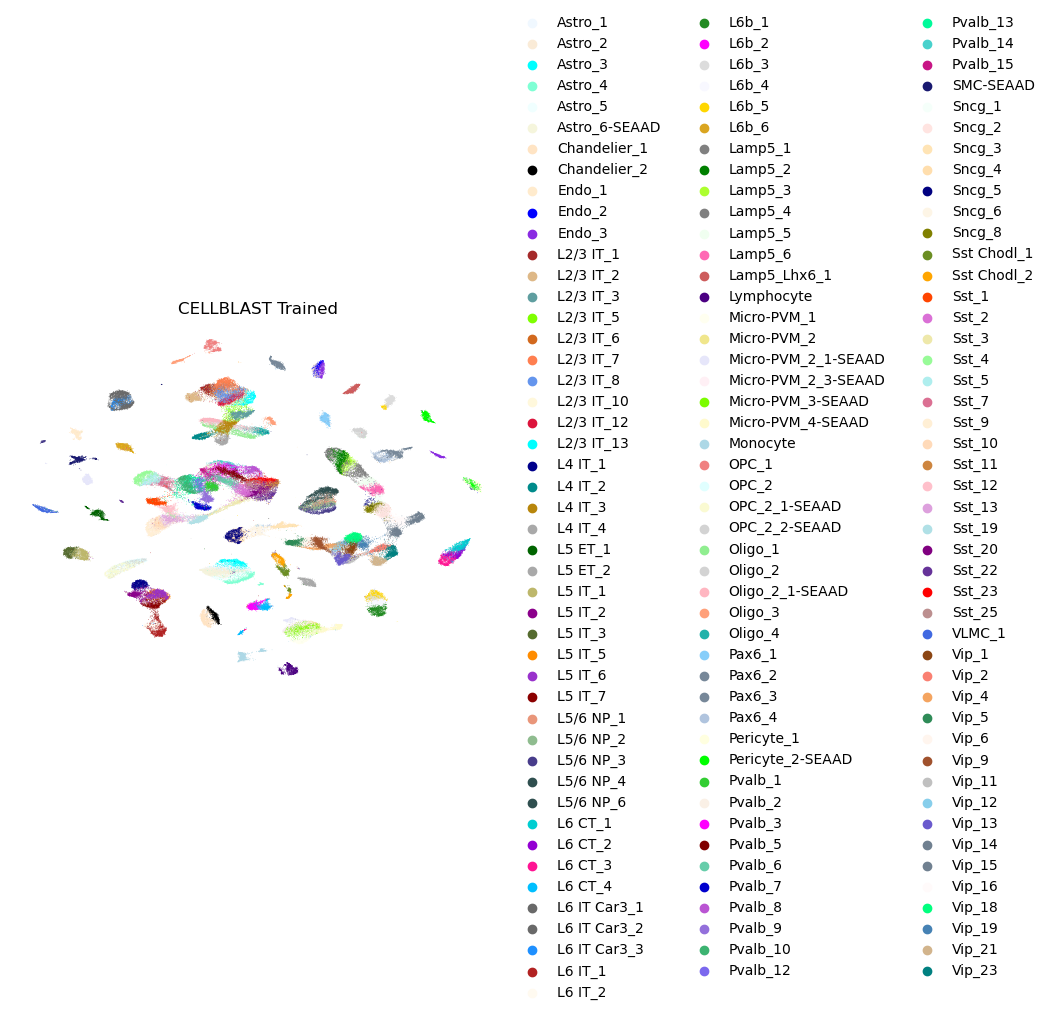

BLAST model has been clustered before!


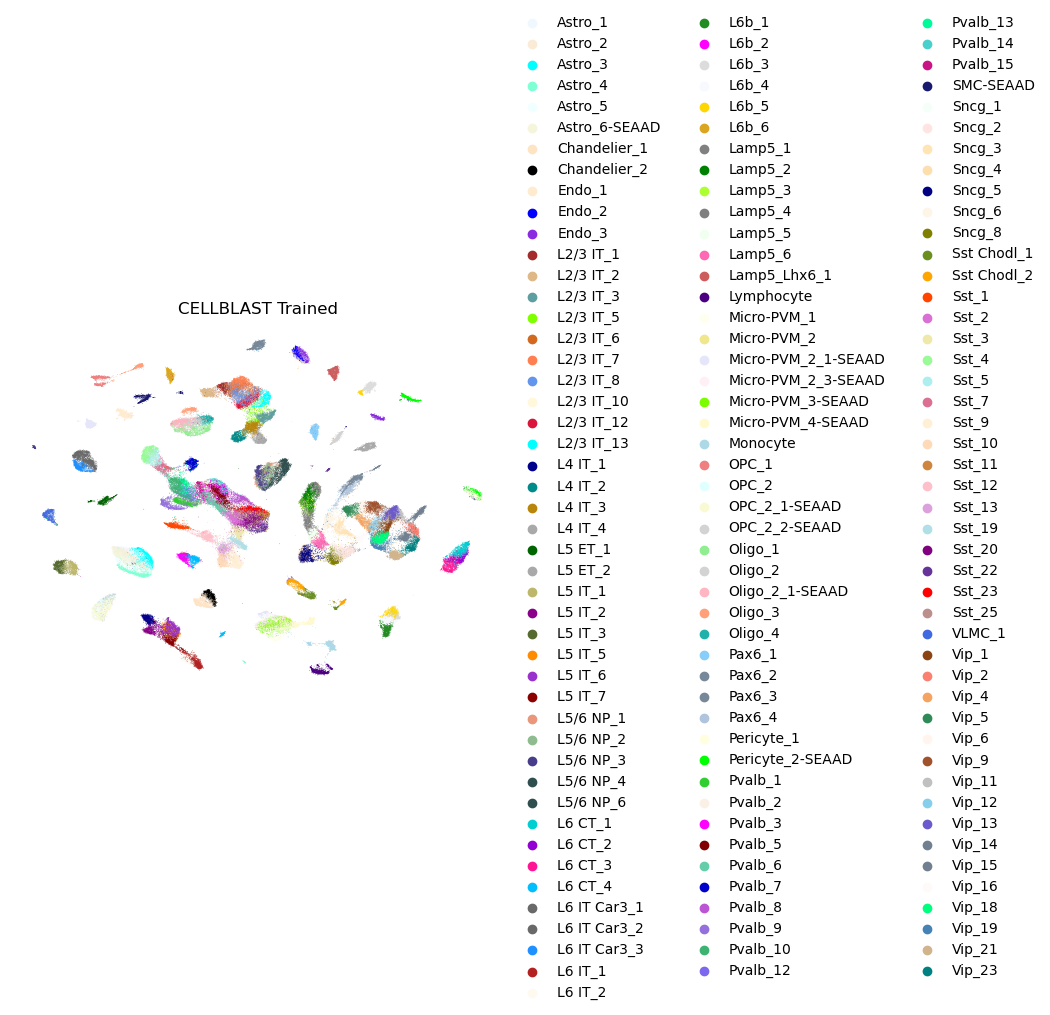

BLAST model has been clustered before!


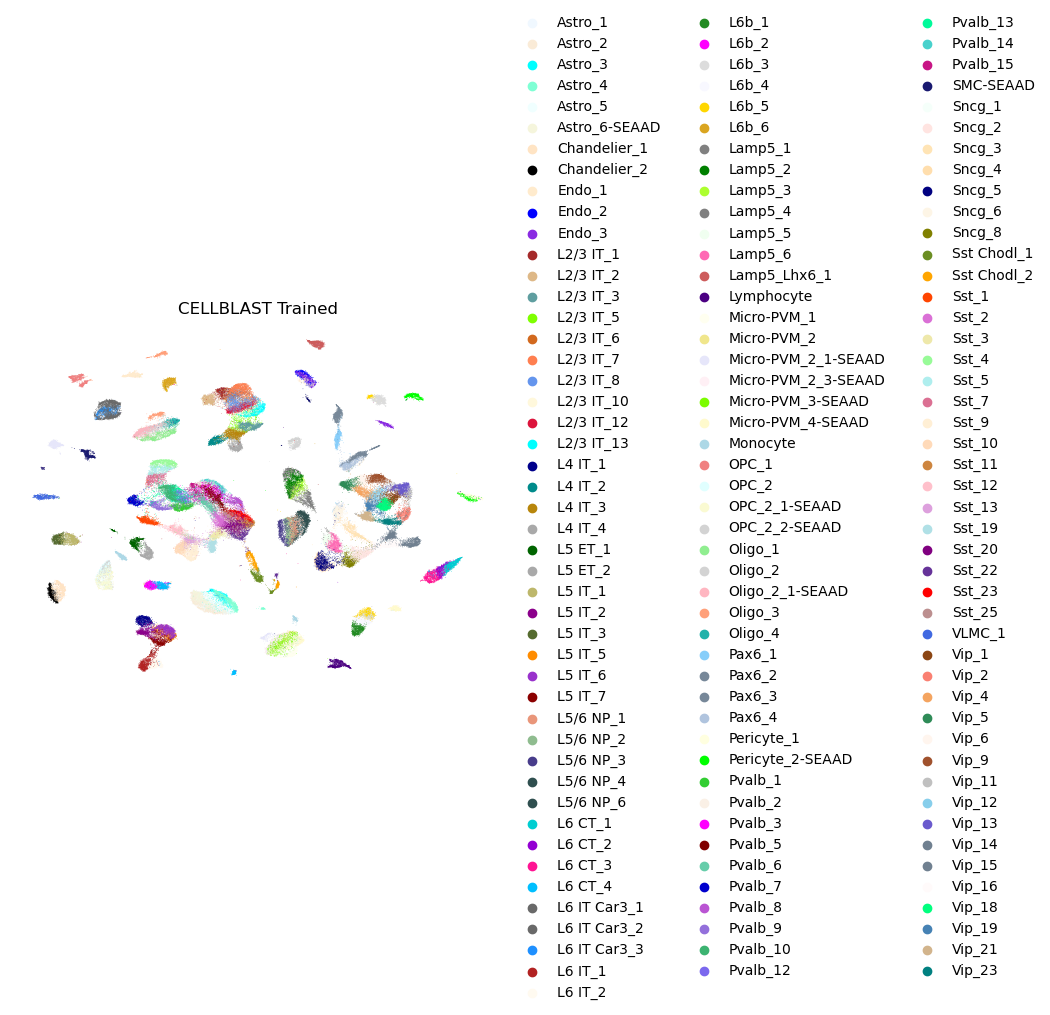

In [6]:
for i in range(3):
        label_model_path_full = label_model_path + f"_{i}"
        if os.path.exists(os.path.join(label_model_path_full, "CELLBLAST.h5ad")) and os.path.exists(os.path.join(label_model_path_full, 'CELLBLAST_umap.pkl')):
                print("BLAST model has been clustered before!" )
                adata_CELLBLAST = sc.read_h5ad(filename=os.path.join(label_model_path_full, "CELLBLAST.h5ad"))
                umap_label = pkl.load(open(os.path.join(label_model_path_full, 'CELLBLAST_umap.pkl'),'rb'))
        else:
                label_model = cellmodel.CELLBLAST.load(label_model_path_full, adata)
                print(label_model)
                adata_CELLBLAST = adata.copy()
                latent_CELLBLAST = label_model.get_latent_representation(adata_CELLBLAST)
                adata_CELLBLAST.obsm["CELLBLAST"] = latent_CELLBLAST
                sc.pp.neighbors(adata_CELLBLAST, use_rep="CELLBLAST") # Using latent representation to form neighbors
                _, umap_label = celltl.umap(adata_CELLBLAST, min_dist=0.3, method='rapids')
                adata_CELLBLAST.write_h5ad(filename=os.path.join(label_model_path_full, "CELLBLAST.h5ad"))
                pkl.dump(umap_label, open(os.path.join(label_model_path_full, 'CELLBLAST_umap.pkl'), 'wb'))

        sc.pl.umap(
                adata_CELLBLAST,
                color=["Supertype"], 
                palette = list(mpl.colors.CSS4_COLORS.values()), 
                frameon=False,
                title="CELLBLAST Trained"
                ) # show the cell after cellblast classification



## Compute Metrics

In [7]:
models = [
    {
        "model_dir" : cell_model_path,
        "label_model_dir" : label_model_path,
        "CELL_kwargs" : cell_kwargs,
        "batch_key" : "method",
        "categorical_covariate_keys": ["library_prep"],
        "splitby": "method",
        "labels_key": "Supertype",
        "cellblast_max_epochs": 10,
        "cellblast_batch_size": 128
    }
]
results, metrics = celltl.compile_results(
    adata,
    "Supertype",
    models=models
)

In [8]:
# print(results)
metrics = pd.DataFrame(metrics)
metrics

In [9]:
np.mean(metrics["f1"])

0.6118363204669504

blast_baseline


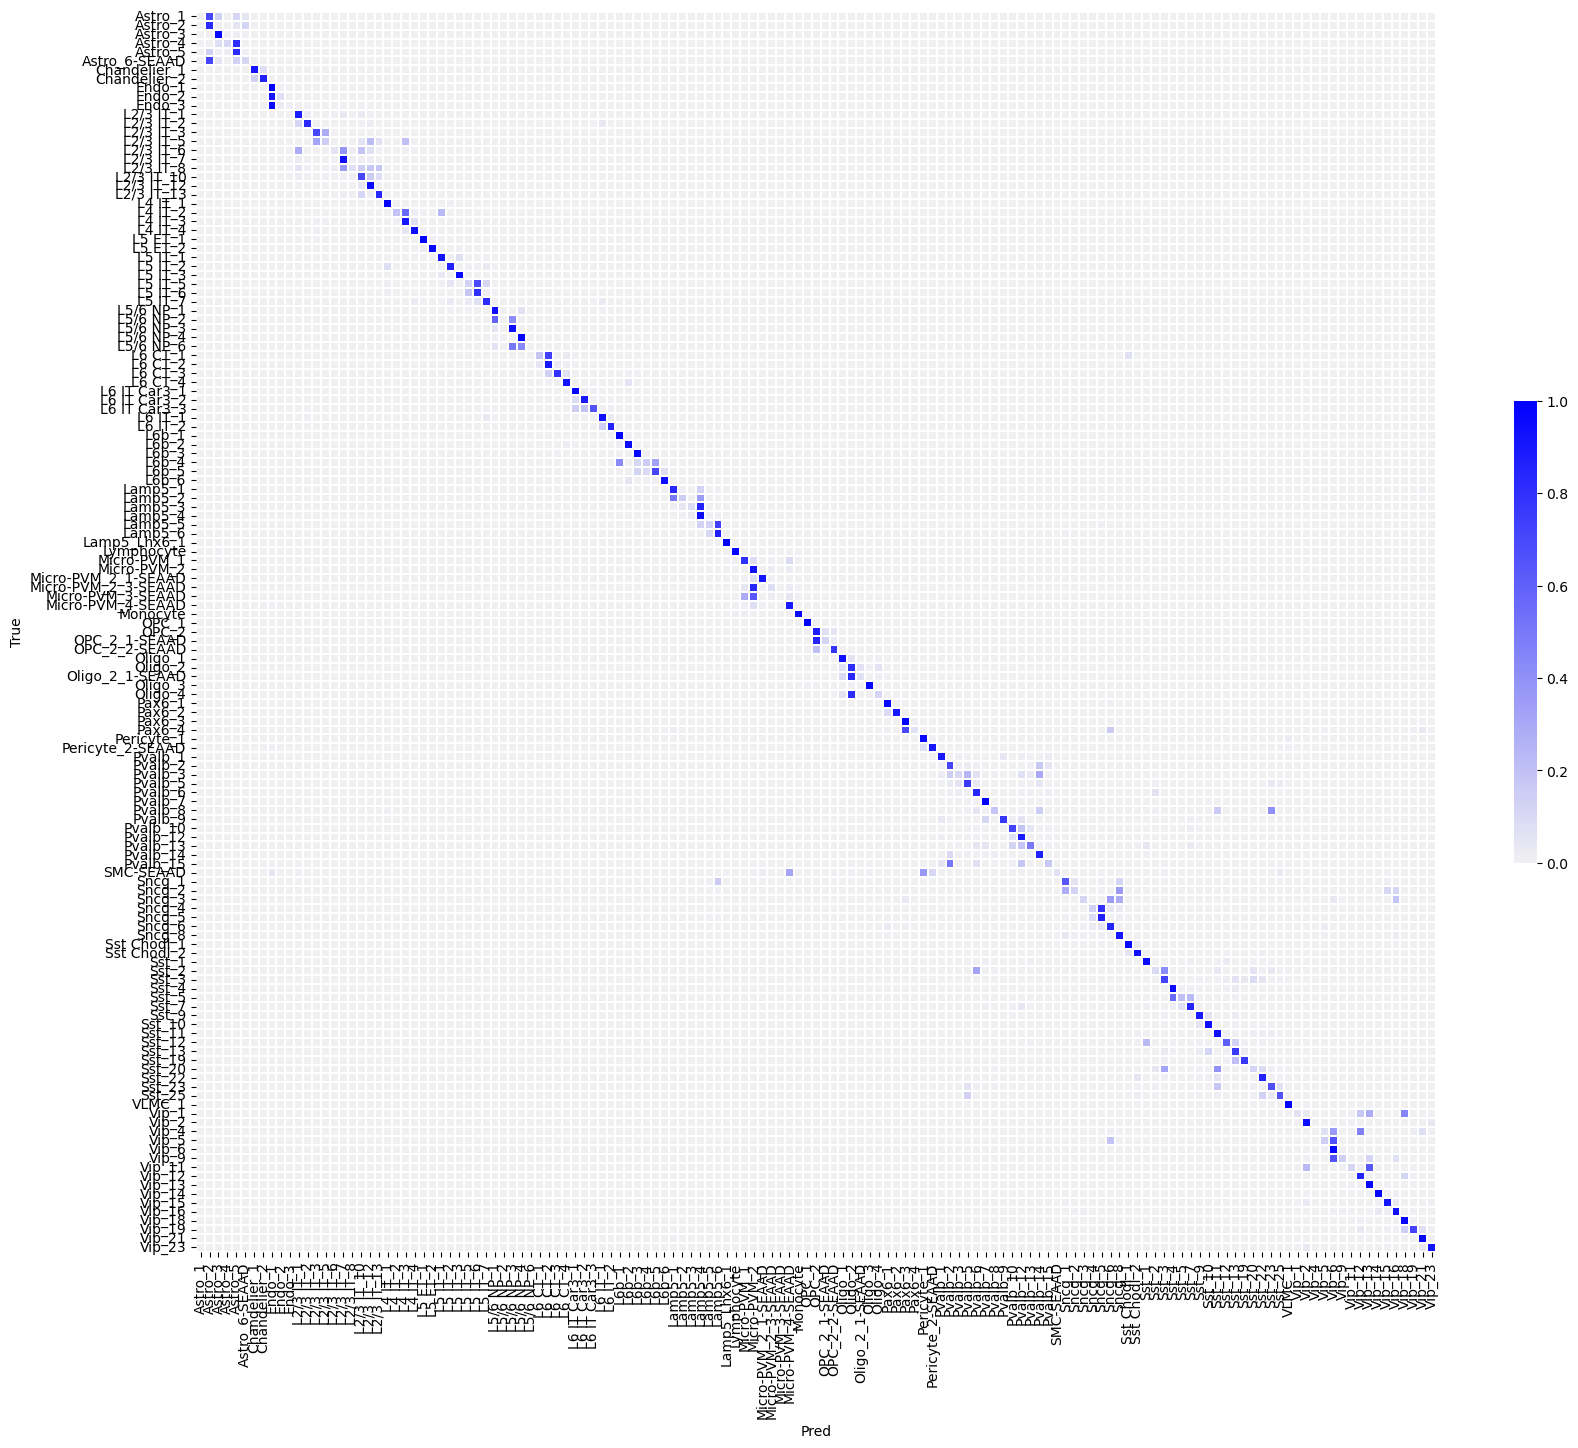

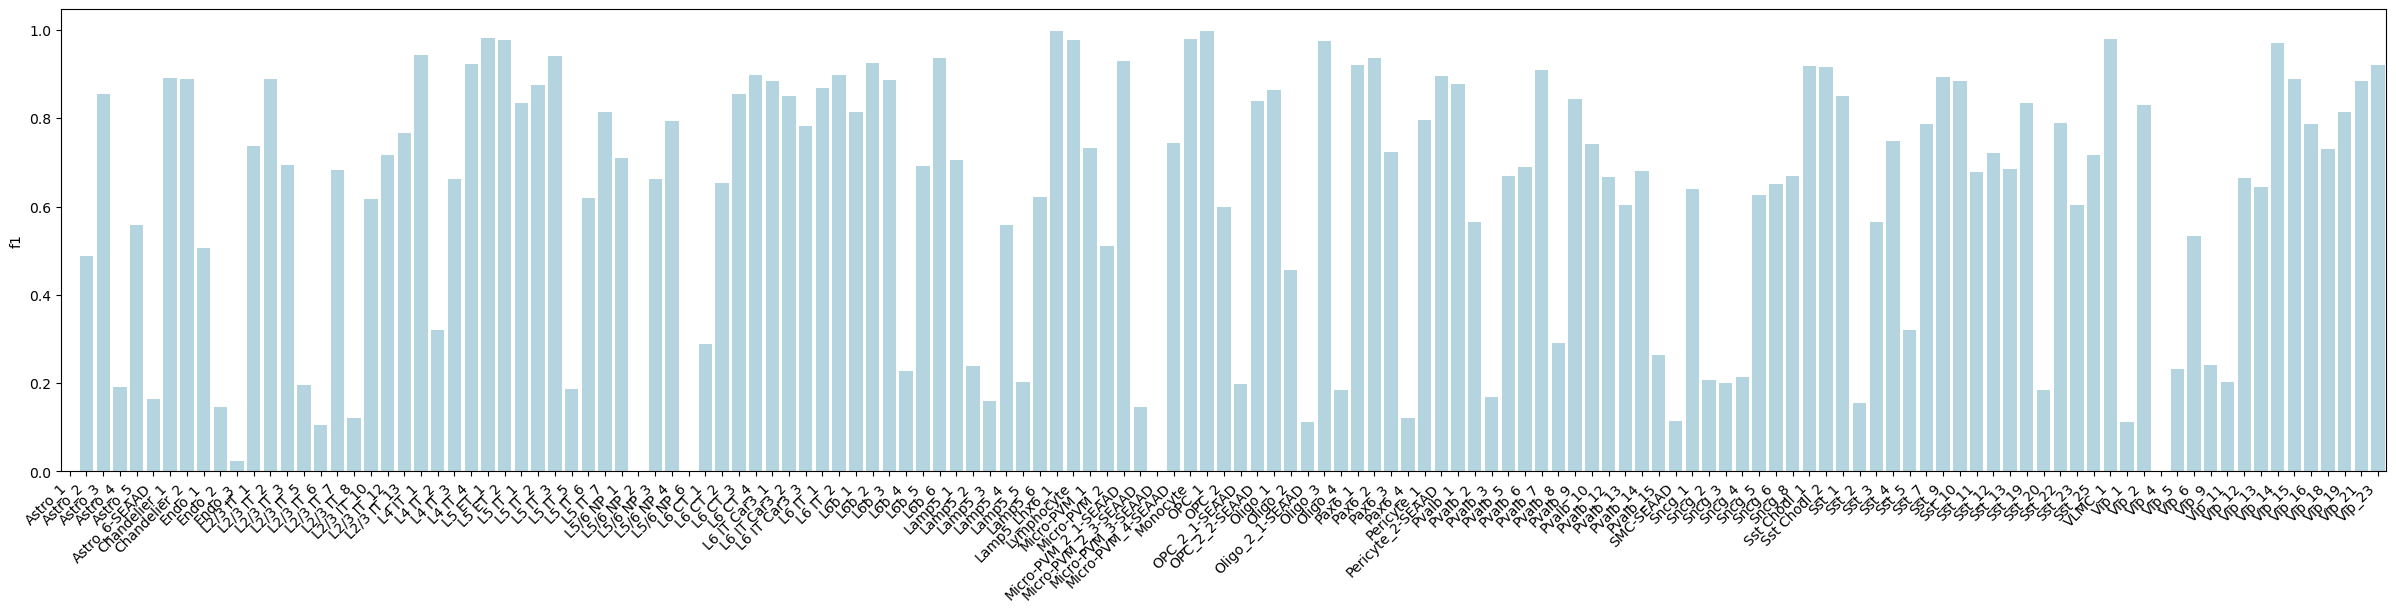

In [9]:
celltl.plot_model_summaries(results, metrics, "Supertype")